In [519]:
import numpy as np
from numpy import polyfit
import pandas as pd
from datetime import date
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv1D
from tensorflow.keras import activations
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [520]:
df = pd.read_pickle('./jewelry_store.pkl')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80625 entries, 0 to 80624
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   date        80625 non-null  datetime64[ns, UTC]
 1   order_id    80625 non-null  int64              
 2   product_id  80625 non-null  int64              
 3   category    80625 non-null  object             
 4   brand_id    77120 non-null  float64            
 5   price       80625 non-null  float64            
 6   user_id     80625 non-null  float64            
 7   main_color  78390 non-null  object             
 8   main_metal  80533 non-null  object             
 9   main_gem    61007 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(3), int64(2), object(4)
memory usage: 6.2+ MB


,date,order_id,product_id,category,brand_id,price,user_id,main_color,main_metal,main_gem
0,2018-12-02 13:53:42+00:00,1925511016616034733,1842214461889315556,jewelry.pendant,1.0,54.66,1.515916e+18,white,gold,sapphire
1,2018-12-02 17:44:02+00:00,1925626951238681511,1835566849434059453,jewelry.pendant,0.0,88.90,1.515916e+18,red,gold,diamond
2,2018-12-02 21:30:19+00:00,1925740842841014667,1873936840742928865,jewelry.necklace,0.0,417.67,1.515916e+18,red,gold,amethyst
3,2018-12-02 22:09:34+00:00,1925760595336888995,1835566854827934449,jewelry.earring,1.0,102.27,1.515916e+18,red,gold,NaN
4,2018-12-02 22:09:34+00:00,1925760595336888995,1600021442638905547,jewelry.earring,0.0,150.55,1.515916e+18,red,gold,diamond


# Various product categories selling details.

In [521]:
df[['category','price']].groupby(by='category')\
    .price.agg([len,sum, min, max])\
    .rename(columns={'len':'sold items count', 'sum':'total income', 'min':'lowest price', 'max':'highest price'})\
    .sort_values(by='sold items count', ascending=False)

,sold items count,total income,lowest price,highest price
category,,,,
jewelry.earring,29051,11511652.07,17.67,34448.60
jewelry.ring,28300,10364450.88,2.60,26424.52
jewelry.pendant,13088,2200662.97,0.99,7513.56
jewelry.bracelet,6188,3056475.12,6.47,4202.74
jewelry.necklace,2361,915307.77,34.11,3482.16
jewelry.brooch,1288,289639.41,6.71,3088.90
jewelry.souvenir,170,6255.06,6.71,312.33
electronics.clocks,167,71032.78,78.89,2998.63
jewelry.stud,12,3629.08,242.33,353.29


Various product categories selling details over the time.

In [522]:
t = df[['category','date', 'price']]
t['sales_date'] = t['date'].dt.year.astype('str') + '-' + t['date'].dt.month.astype('str')
t['sales_date'] = pd.to_datetime(t['sales_date'])
t['sales_date'] = t['sales_date'].apply(lambda x: x.strftime('%Y-%m'))
t.drop(columns=['date'], inplace=True)
t = t.sort_values(by='sales_date').rename(columns={'price':'income'})
t = t.groupby(by=['sales_date','category']).sum()
df_t = t.unstack('sales_date').fillna(0)
df_t

C:\Users\justy\AppData\Local\Temp\ipykernel_74708\252817668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['sales_date'] = t['date'].dt.year.astype('str') + '-' + t['date'].dt.month.astype('str')
C:\Users\justy\AppData\Local\Temp\ipykernel_74708\252817668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['sales_date'] = pd.to_datetime(t['sales_date'])
C:\Users\justy\AppData\Local\Temp\ipykernel_74708\252817668.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

income                                          \
sales_date           2018-12   2019-01   2019-02   2019-03   2019-04   
category                                                               
electronics.clocks    885.07    354.80   4953.26    302.05   1681.92   
jewelry.bracelet     3000.60  15508.98  27611.79  19521.63  23887.16   
jewelry.brooch        464.20    297.51   2137.20    829.54  11097.51   
jewelry.earring     13705.49  76877.03  74824.63  69827.40  64861.95   
jewelry.necklace     2024.24   3802.75   3646.36   9226.97   5528.89   
jewelry.pendant      2114.12  18846.08  17345.04  13373.17  11060.43   
jewelry.ring         5588.19  58574.38  87290.73  79287.08  79404.55   
jewelry.souvenir        0.00    397.82     10.27     44.75     20.54   
jewelry.stud            0.00      0.00      0.00      0.00      0.00   

                                                                         ...  \
sales_date           2019-05    2019-06    2019-07    2019-08   2019-09  ...   
category                                                                 ...   
electronics.clocks   2525.76     340.41    2449.05       0.00    215.74  ...   
jewelry.bracelet    18198.81   25298.40   33645.63   44531.18  32011.56  ...   
jewelry.brooch       1067.91    1239.79    1497.44    1296.99    934.53  ...   
jewelry.earring     56246.11   63376.18   91043.87  129724.82  70255.17  ...   
jewelry.necklace     9577.67    2365.35   17903.26    6707.62   7416.72  ...   
jewelry.pendant      9659.99    9071.70   19815.48   21338.03   9495.86  ...   
jewelry.ring        95789.09  106018.56  133635.20  152440.11  90939.15  ...   
jewelry.souvenir        0.00      19.72       6.71       0.00     58.99  ...   
jewelry.stud            0.00       0.00     353.29       0.00      0.00  ...   

                                                                           \
sales_date            2021-03    2021-04    2021-05    2021-06    2021-07   
category                                                                    
electronics.clocks    1227.30    1044.93    1479.71    3061.39    5083.28   
jewelry.bracelet    143928.84  104552.45  133256.69  116137.53  140184.91   
jewelry.brooch       15143.38    7607.75   12053.73    7514.18   11729.66   
jewelry.earring     550234.77  538559.38  466673.40  448935.86  605537.67   
jewelry.necklace     38981.40   42676.54   40537.38   30695.93   46518.63   
jewelry.pendant     115718.13   82083.83  100698.27  110324.45  114965.28   
jewelry.ring        476401.52  442847.74  472215.18  445699.37  455801.88   
jewelry.souvenir       395.19     363.16     207.38     501.48     543.15   
jewelry.stud             0.00       0.00       0.00       0.00       0.00   

                                                                           
sales_date            2021-08    2021-09    2021-10     2021-11   2021-12  
category                                                                   
electronics.clocks    1917.61    6975.74    2651.18     5100.00      0.00  
jewelry.bracelet    263588.96  174666.94  136288.51   333083.37   4549.81  
jewelry.brooch       18887.98   15136.98   15911.24    23933.91    292.19  
jewelry.earring     989682.13  688838.88  600262.21  1166860.97  19573.14  
jewelry.necklace     68150.84   39300.92   26819.23    55686.00     58.77  
jewelry.pendant     175361.57  121937.35   99669.67   198290.00   1821.77  
jewelry.ring        857298.32  562813.23  456289.06   952217.35  14594.08  
jewelry.souvenir       415.04     185.74     185.74      431.20      0.00  
jewelry.stud             0.00       0.00       0.00      353.29      0.00  

[9 rows x 37 columns]

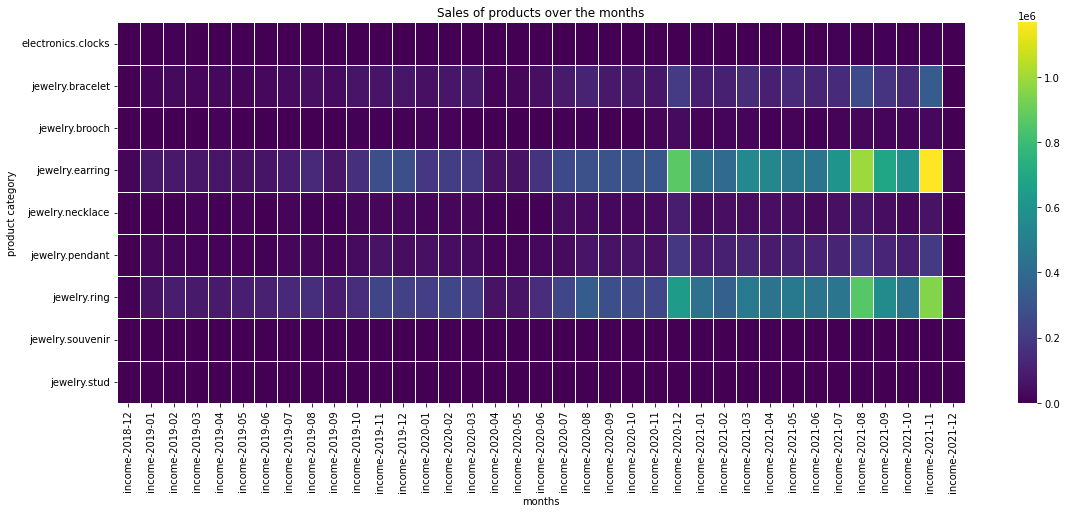

In [523]:
plt.figure(figsize =(19,7))
ax = sns.heatmap(df_t, linewidth = 0.5, cmap="viridis")
plt.title('Sales of products over the months')
plt.xlabel('months')
plt.ylabel('product category')
plt.show()

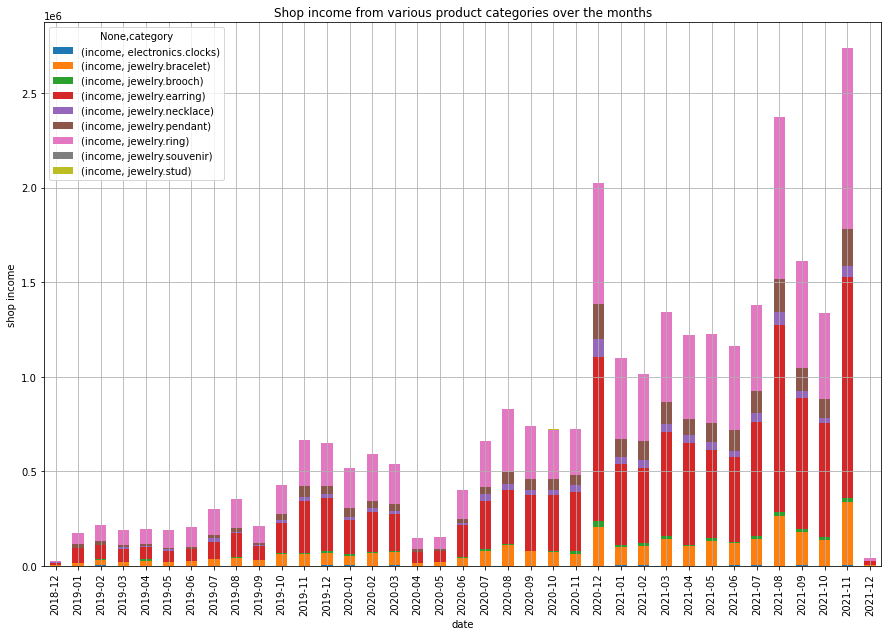

In [524]:
t.unstack('category').fillna(0).plot(kind='bar', figsize=(15,10),  stacked=True, xlabel='date', ylabel='shop income')
plt.title('Shop income from various product categories over the months')
plt.grid()

# 

## Forecasting future shop income (based on monthly revenue).

Forecasting using polynomial regression. 

In [525]:
monthIn_df = df[['category','date', 'price']].sort_values(by='date')
monthIn_df['sales_date'] = monthIn_df['date'].dt.year.astype('str') + '-' + monthIn_df['date'].dt.month.astype('str')
monthIn_df['sales_date'] = pd.to_datetime(monthIn_df['sales_date'], format='%Y-%m')
monthIn_df.drop(columns=['date'], inplace=True)
monthIn_df

,category,price,sales_date
0,jewelry.pendant,54.66,2018-12-01
1,jewelry.pendant,88.90,2018-12-01
2,jewelry.necklace,417.67,2018-12-01
3,jewelry.earring,102.27,2018-12-01
4,jewelry.earring,150.55,2018-12-01
...,...,...,...
80620,jewelry.ring,145.62,2021-12-01
80621,jewelry.earring,301.23,2021-12-01
80622,jewelry.earring,630.00,2021-12-01
80623,jewelry.earring,83.42,2021-12-01


In [526]:
monthIn_df = monthIn_df.groupby(['sales_date']).price.agg([sum]).rename(columns={'sum':'income'}).reset_index()
monthIn_df.drop(columns=['sales_date'], inplace=True)
monthIn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   income  37 non-null     float64
dtypes: float64(1)
memory usage: 424.0 bytes


In [532]:
temp_df = monthIn_df.reset_index()
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   index   37 non-null     int64
 1   income  37 non-null     int64
dtypes: int64(2)
memory usage: 720.0 bytes


In [552]:
temp_df['income'] = temp_df['income'].astype(np.int64)
monthIn_df['income'] = monthIn_df['income'].astype(np.int64)

In [553]:
X = temp_df.to_numpy()

In [554]:
p = np.linspace(0, 42, num=43)
deg = 3

coeffs = polyfit(X[:-2,0], X[:-2,1], deg=deg).reshape(-1,1)
X = np.concatenate(list(map(lambda i: p.reshape(1, -1)**i, reversed(range(deg+1)))))
Y = (coeffs.T @ X).flatten()

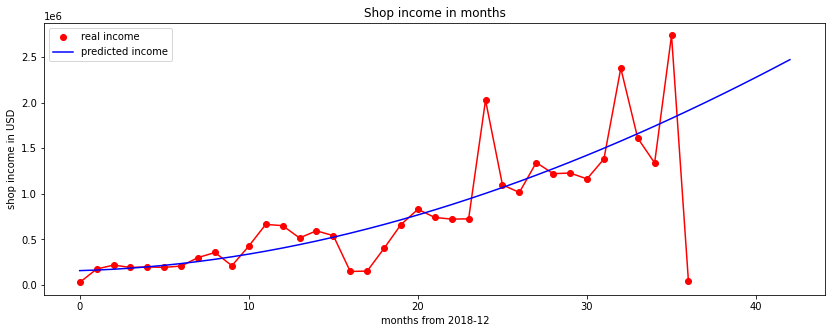

In [555]:
fig, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(monthIn_df, 'ro', label='real income')
ax.plot(monthIn_df, 'r')
ax.plot(p, Y, 'b', label = 'predicted income')
plt.title('Shop income in months')
plt.legend()
plt.xlabel('months from 2018-12')
plt.ylabel('shop income in USD')
plt.show()

# 

# Forecasting future shop income (based on daily revenue).

Forecasting using polynomial regression.

In [557]:
dayIn_df = df[['category','date', 'price']]
dayIn_df['sales_date'] = dayIn_df['date'].dt.year.astype('str') + '-' + dayIn_df['date'].dt.month.astype('str') + '-' \
                            + dayIn_df['date'].dt.day.astype('str')
dayIn_df['sales_date'] = pd.to_datetime(dayIn_df['sales_date'], format='%Y-%m-%d')
dayIn_df.drop(columns=['date'], inplace=True)
dayIn_df.sort_values(by='sales_date')
dayIn_df = dayIn_df.groupby(by=['sales_date']).sum()
dayIn_df.head()

C:\Users\justy\AppData\Local\Temp\ipykernel_74708\2996458136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dayIn_df['sales_date'] = dayIn_df['date'].dt.year.astype('str') + '-' + dayIn_df['date'].dt.month.astype('str') + '-' \
C:\Users\justy\AppData\Local\Temp\ipykernel_74708\2996458136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dayIn_df['sales_date'] = pd.to_datetime(dayIn_df['sales_date'], format='%Y-%m-%d')
C:\Users\justy\AppData\Local\Temp\ipykernel_74708\2996458136.py:5: SettingWithCopyW

,price
sales_date,
2018-12-02,897.47
2018-12-03,978.85
2018-12-04,3486.05
2018-12-05,1246.58
2018-12-06,1417.26


In [558]:
dayIn_df = dayIn_df.groupby(['sales_date']).price.agg([sum]).rename(columns={'sum':'income'}).reset_index()
dayIn_df.drop(columns=['sales_date'], inplace=True)
dayIn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   income  1081 non-null   float64
dtypes: float64(1)
memory usage: 8.6 KB


In [559]:
temp_df = dayIn_df.reset_index()
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1081 non-null   int64  
 1   income  1081 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 17.0 KB


In [560]:
temp_df['income'] = temp_df['income'].astype(np.int64)
dayIn_df['income'] = dayIn_df['income'].astype(np.int64)

In [561]:
X = temp_df.to_numpy()

In [562]:
p = np.linspace(0, 1200, num=1201)
deg = 4

coeffs = polyfit(X[:-2,0], X[:-2,1], deg=deg).reshape(-1,1)
X = np.concatenate(list(map(lambda i: p.reshape(1, -1)**i, reversed(range(deg+1)))))
Y = (coeffs.T @ X).flatten()

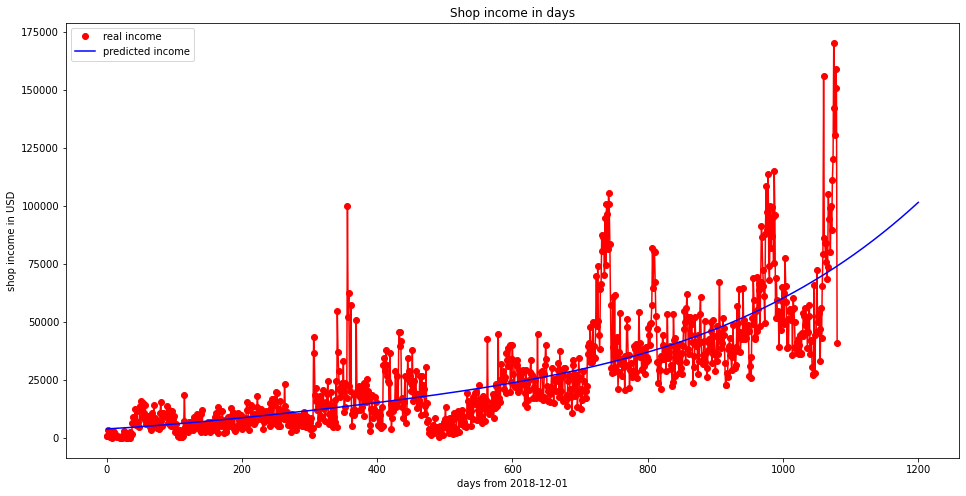

In [564]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(dayIn_df, 'ro', label='real income')
ax.plot(dayIn_df, 'r')
ax.plot(p, Y, 'b', label = 'predicted income')
plt.title('Shop income in days')
plt.legend()
plt.xlabel('days from 2018-12-01')
plt.ylabel('shop income in USD')
plt.show()

# 

## Prediction of bracelet sales revenue.

Forecasting values in time series using deep learning

In [361]:
t = df[df['category']=='jewelry.bracelet'][['date', 'price']]
t['sales_date'] = t['date'].dt.year.astype('str') + '-' + t['date'].dt.month.astype('str') + '-' + t['date'].dt.day.astype('str')
t['sales_date'] = pd.to_datetime(t['sales_date'], format='%Y-%m-%d')
t.drop(columns=['date'], inplace=True)
t.sort_values(by='sales_date')
t = t.groupby(by=['sales_date']).sum()
t.head()

,price
sales_date,
2018-12-04,335.48
2018-12-05,130.71
2018-12-06,168.74
2018-12-09,200.56
2018-12-12,152.77


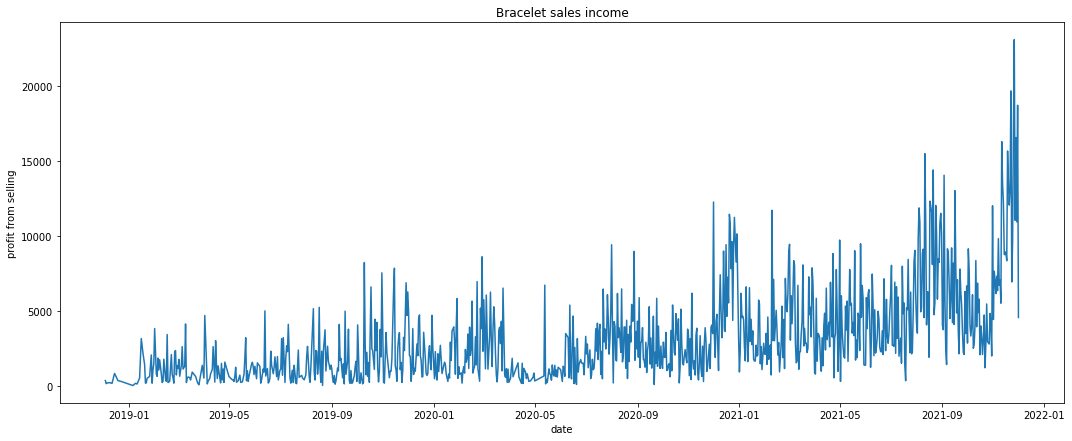

In [362]:
plt.figure(figsize=(18,7))
plt.plot(t)
plt.title('Bracelet sales income')
plt.xlabel('date')
plt.ylabel('profit from selling')
plt.show()

In [340]:
train = t['price'].iloc[:-120]
test = t['price'].iloc[-120:]

In [341]:
def timeseries_dataset_from_array(data, win):
    result=[]
    for i in range(len(data)-win+1):
        result.append(data[i:i+win])
    return result

In [342]:
train_x = np.array(timeseries_dataset_from_array(list(train), 12))
test_x = np.array(timeseries_dataset_from_array(list(test), 12))

In [343]:
train_x.shape

(821, 12)

In [344]:
train_x = np.reshape(train_x, (train_x.shape[0],12,1))
test_x = np.reshape(test_x, (test_x.shape[0],12,1))

In [345]:
train_y = np.array(train[11:])
test_y = np.array(test[11:])

In [378]:
model = Sequential()
model.add(Input(shape=(12,1)))
model.add(Conv1D(4,12, activation=activations.relu))
model.add(Dense(12, activation=activations.relu))
model.add(Dense(1))

In [379]:
model.compile(loss='mse')

In [380]:
es = EarlyStopping(patience=50, verbose=1)
rlr = ReduceLROnPlateau(patience=25, verbose=1)

In [381]:
model.fit(train_x, train_y, epochs=2000, validation_split=0.3, callbacks=[es, rlr])

Epoch 1/2000
18/18 [==============================] - 1s 9ms/step - loss: 6257251.5000 - val_loss: 19756434.0000 - lr: 0.0010
Epoch 2/2000
18/18 [==============================] - 0s 3ms/step - loss: 4960462.5000 - val_loss: 13514630.0000 - lr: 0.0010
Epoch 3/2000
18/18 [==============================] - 0s 3ms/step - loss: 4046497.0000 - val_loss: 9251291.0000 - lr: 0.0010
Epoch 4/2000
18/18 [==============================] - 0s 3ms/step - loss: 3733959.5000 - val_loss: 7931716.5000 - lr: 0.0010
Epoch 5/2000
18/18 [==============================] - 0s 3ms/step - loss: 3605496.7500 - val_loss: 7701491.0000 - lr: 0.0010
Epoch 6/2000
18/18 [==============================] - 0s 3ms/step - loss: 3631064.2500 - val_loss: 7757563.5000 - lr: 0.0010
Epoch 7/2000
18/18 [==============================] - 0s 3ms/step - loss: 3596095.2500 - val_loss: 7698444.0000 - lr: 0.0010
Epoch 8/2000
18/18 [==============================] - 0s 3ms/step - loss: 3545715.5000 - val_loss: 7581720.5000 - lr: 0.001

In [382]:
pred = model.predict(test_x)
pred.shape

(109, 1, 1)

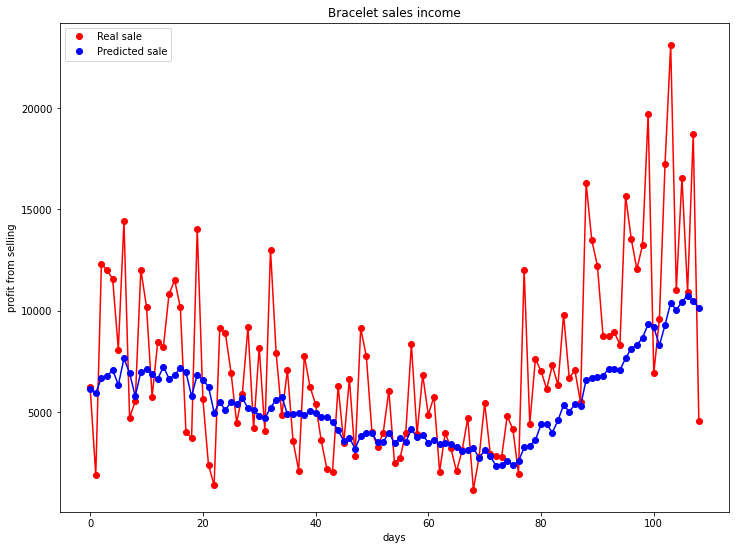

In [383]:
plt.figure(figsize=(12,9))
plt.plot(test_y, 'ro', label = 'Real sale')
plt.plot(test_y, 'r')
plt.plot(pred.reshape((109)), 'bo', label = 'Predicted sale')
plt.plot(pred.reshape((109)), 'b')
plt.title('Bracelet sales income')
plt.xlabel('days')
plt.ylabel('profit from selling')
plt.legend()
plt.show()